# ADULT INCOME PREDICTION

## Introduction

The income gap between people has always been significant. Some people earn millions every year. Some people are not even able to survive with their salary. 

During the late 1940s and the early 1970s, people's income grew rapidly and inflation doubled.[1] This was in part due to the end of the World Wars.[1] However, the income of richer households increased significantly, while the income of poorer households increased much slower.[1] This widened the income gap between the rich and poor households.[1] Furthermore, events such as the the 2008 financial crisis continue to emphasize and worsen income inequality in the United States.[1]

We know from recent research that gender identity, age, race, and education are all social factors that contribute to income inequality.[4] Education in particular improves economic mobility and increases income generating opportunies, which contributes to greater economic growth.[4] According to Georgetown University Center on Education and the Workforce, 84% of people with a college degree earn more than those who only received a high school diploma.[4] 

In this project, we will use the variables age, final weight, education level, and working hours per week as predictor variables to determine whether an individual will make less than or more than 50K a year. This will help us get a better idea of the impact these factors can have on income. For the data, we will use a dataset of the 1994 US Census from the UCL machine learning repository, titled “Adult Data Set” [2]. 

There were originally 15 variables in the dataset (c = categorical, n = numerical): 
1. Age (n)
2. Work Class (c)
3. Final Weight (n): The number of people with the same attributes
4. Education (c)
5. Education Number (n): Highest degree achieved (1 = lowest, 16 = highest)
6. Marital Status (c)
7. Occupation (c)
8. Relationship (c)
9. Race (c)
10. Sex (c)
11. Capital Gain (n) 
12. Capital Loss (n)
13. Hours per week (n)
14. Native Country (c)
15. Income (target): <=50K, >50K

## Methods & Results

The markdown cells below will describe the methods we used along with the code associated with it.

First, we need to load all the libraries that are required for our analysis.

In [9]:
library(tidyverse)
library(digest)
library(repr)
library(tidymodels)
library(GGally)

Then, we load the data in from the web. The file that we downloaded did not have column names included, so we added those in.

In [10]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

download.file(url, "data.csv")

names <- c("age", "workclass", "fnlwgt", "education", "education_num", "marital_status", "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss", "hours_per_week", "native_country", "income")
census <- read_csv("data.csv", col_names = names) %>%
    mutate(income = as_factor(income))

Parsed with column specification:
cols(
  age = col_double(),
  workclass = col_character(),
  fnlwgt = col_double(),
  education = col_character(),
  education_num = col_double(),
  marital_status = col_character(),
  occupation = col_character(),
  relationship = col_character(),
  race = col_character(),
  sex = col_character(),
  capital_gain = col_double(),
  capital_loss = col_double(),
  hours_per_week = col_double(),
  native_country = col_character(),
  income = col_character()
)



Here we take a look at the first few rows of our data set. This tells us interesting information such as the column types, category values, etc. We can see right away that there are a lot of columns, but it is likely that not all of them are beneficial to our analysis.

In [11]:
head(census)

age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


We decided to take a look at capital_gain and capital_loss right away, since the brief summary above showed many values of 0 for both these columns. As shown in the 2 graphs below (“Relationship Between Capital Gain and Income Level” and “Relationship Between Capital Loss and Income Level”), these two variables are not very indicative of income level. There are many individuals in both income categories with 0 capital gain and loss. Therefore, for our analysis we will not be using these two variables.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



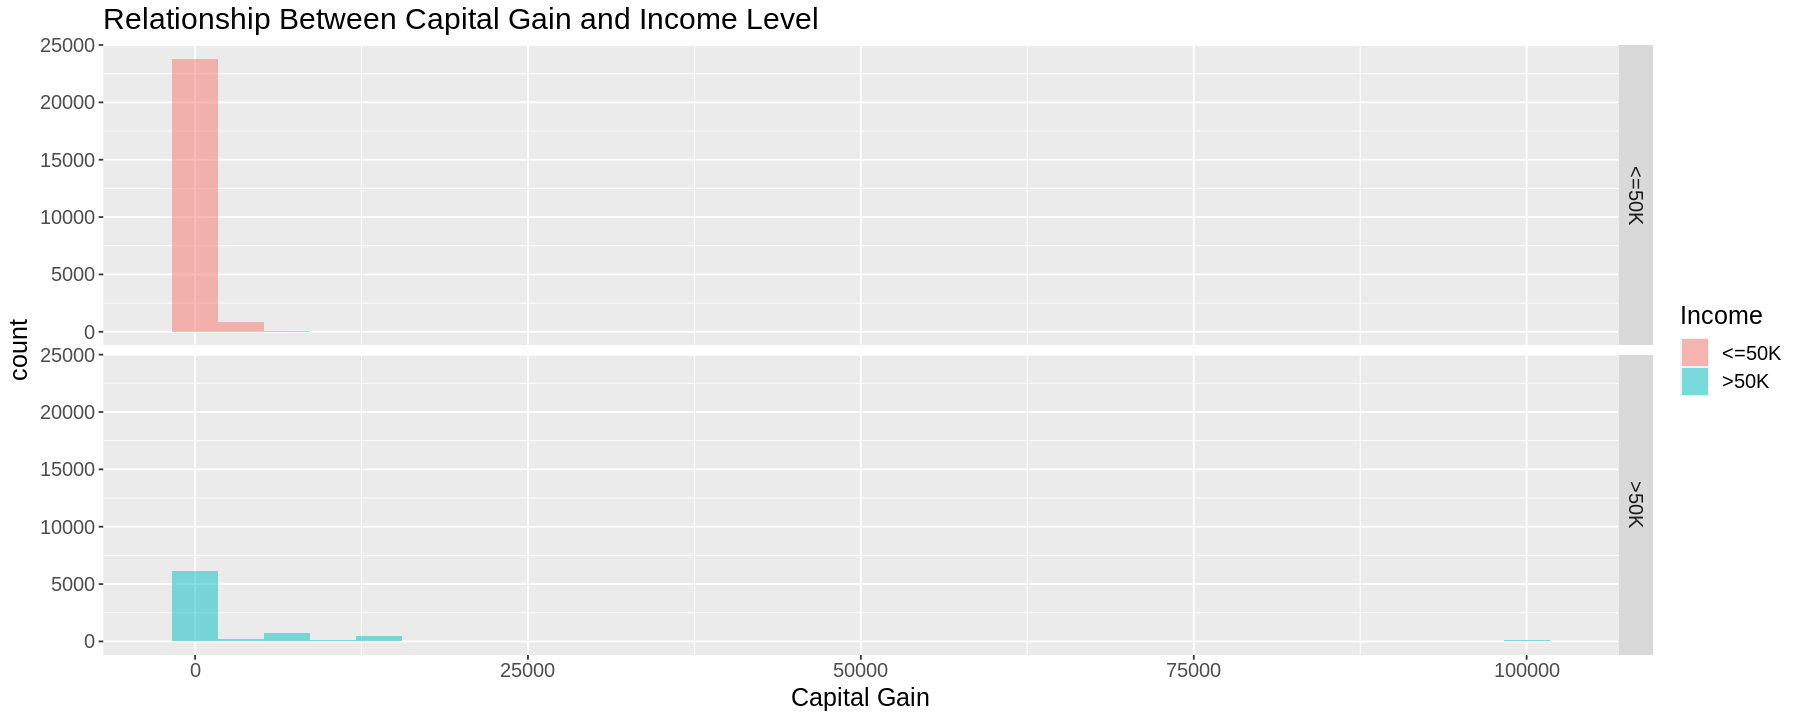

In [12]:
options(repr.plot.width = 15, repr.plot.height = 6)
gain <- census %>%
    ggplot(aes(x = capital_gain, fill = income)) +
    geom_histogram(alpha = 0.5, position = "identity") +
    facet_grid(rows = vars(income)) +
    labs(x = "Capital Gain", fill = "Income") + 
    ggtitle("Relationship Between Capital Gain and Income Level") + 
    theme(text = element_text(size = 15)) 
gain

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



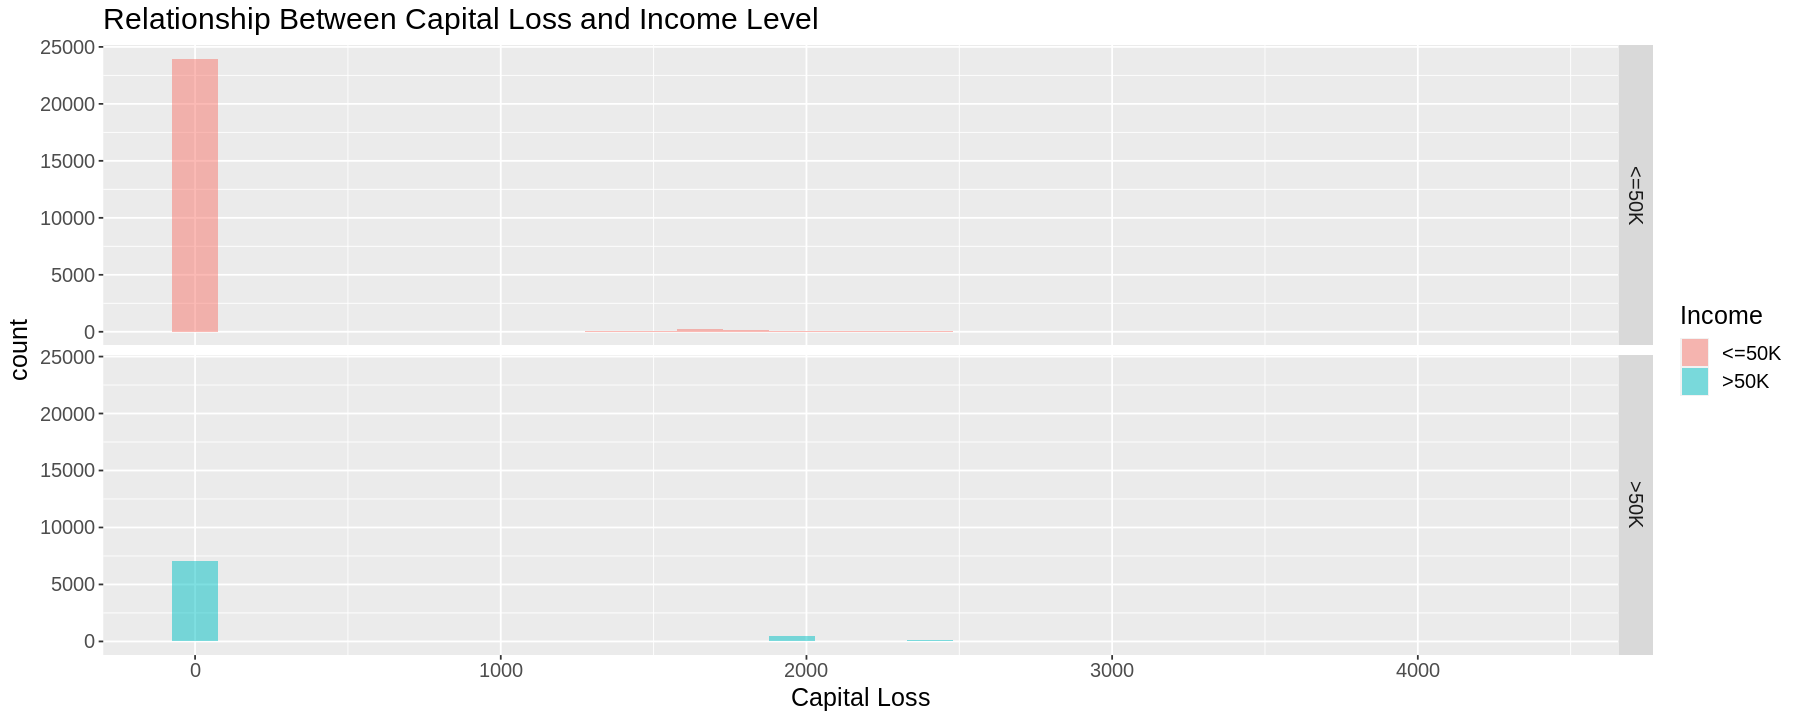

In [13]:
loss <- census %>%
    ggplot(aes(x = capital_loss, fill = income)) +
    geom_histogram(alpha = 0.5, position = "identity") +
    facet_grid(rows = vars(income)) +
    labs(x = "Capital Loss", fill = "Income") + 
    ggtitle("Relationship Between Capital Loss and Income Level") + 
    theme(text = element_text(size = 15)) 
loss

To tidy the data, we selected only the predictors we will be working with. As mentioned above, we will be removing capital_gain and capital_loss. We will also be omitting all categorical variables in our analysis since we will not be able to analyze them with K-NN classification. We will discuss more about K-NN classification in our data analysis section.

In [14]:
census_variables <- census %>%
    select(age, fnlwgt, education_num, hours_per_week, income)
head(census_variables)

age,fnlwgt,education_num,hours_per_week,income
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
39,77516,13,40,<=50K
50,83311,13,13,<=50K
38,215646,9,40,<=50K
53,234721,7,40,<=50K
28,338409,13,40,<=50K
37,284582,14,40,<=50K


To build our classifier, we split our data into train and test sets with a 75% training split. This split allows us to have a good amount of data to train our model with, while leaving sufficient data to test our model. We split the data before performing any exploratory data analysis because we are not supposed to know any information about the test set. That would violate the Golden Rule! Therefore, we will only be summarizing and visualizing our training data.

In [15]:
set.seed(123)

census_split <- initial_split(census_variables, prop = 0.75, strata = income)  
census_train <- training(census_split)   
census_test <- testing(census_split)

head(census_train)
# 24421 x 13
# 24421 observations in the training set with 13 categories

age,fnlwgt,education_num,hours_per_week,income
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
39,77516,13,40,<=50K
50,83311,13,13,<=50K
38,215646,9,40,<=50K
53,234721,7,40,<=50K
37,284582,14,40,<=50K
52,209642,9,45,>50K


### Preliminary Exploratory Data Analysis

Now, we explore our training data with various tables and graphs to get a better sense of the data we are working with before we create our model.

#### Tables

The tables below help summarize the data we will be using.

##### Table 1. Number of observations in each class. 

In [16]:
num_obs <- nrow(census_train)
percentage_income <- census_train %>% 
    group_by(income) %>%
    summarize(
        count = n(),
        percentage = n() / num_obs * 100
    )
percentage_income

`summarise()` ungrouping output (override with `.groups` argument)



income,count,percentage
<fct>,<int>,<dbl>
<=50K,18540,75.91827
>50K,5881,24.08173


About 76% of the individuals in the training set make less than or equal to 50k a year, while 24% make greater than 50k a year. It looks like there is a slight class imbalance, but it should not make too much of a difference since there is still a good amount of data in both classes. Another reason why we did not choose to balance the data in this project is due to the fact that step_upsample is not in this course's libraries.

##### Table 2. Number of missing values.

In [17]:
missing_count <- census_train %>%
    filter(age == "?" | education_num == "?" | hours_per_week == "?" | fnlwgt == "?" | income == "?")
missing_count

age,fnlwgt,education_num,hours_per_week,income
<dbl>,<dbl>,<dbl>,<dbl>,<fct>


The code above tells us whether any of our variables have missing values, which are shown as "?" in this data set. There are no missing values for the predictors that we will be using.

##### Table 3. Means of predictor variables we plan to use.

In [18]:
continuous_means <- census_train %>%
    select(age:hours_per_week) %>%
    colMeans()
continuous_means

age         fnlwgt  education_num hours_per_week 
      38.56857   189722.35224       10.07125       40.40387

The mean age in the 1994 US census is 38.6 years, average final weight is 189722, average education level is 10 and on average individuals work 40 hours per week.

#### Graphs

We used histograms to visualize the distributions of 3 of our predictor variables becuase we found that they were interesting and represented our data well. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



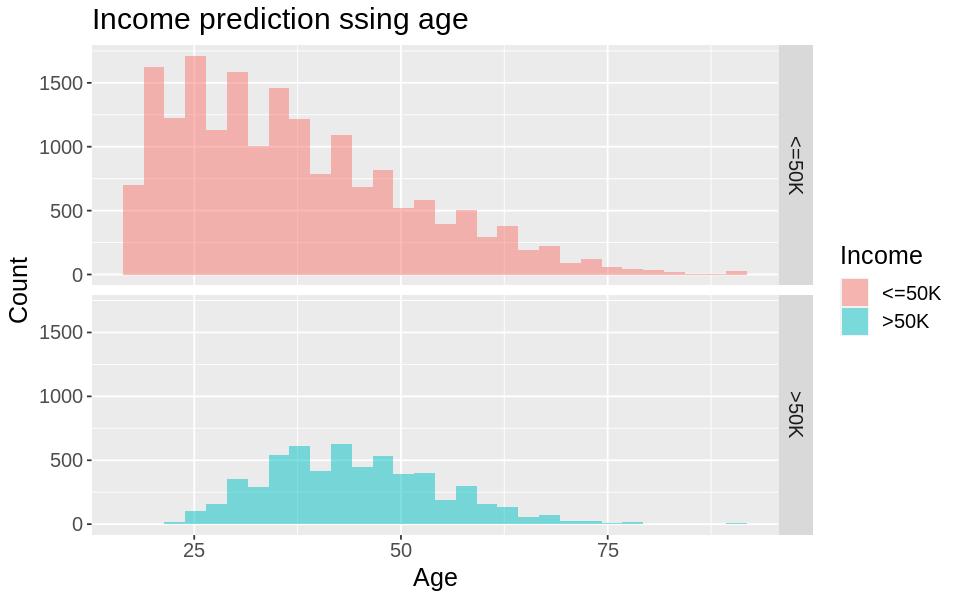

In [19]:
options(repr.plot.width = 8, repr.plot.height = 5)
age_hist <- census_train %>%
    ggplot(aes(x = age, fill = income)) +
    geom_histogram(alpha = 0.5, position = "identity") +
    facet_grid(rows = vars(income)) +
    labs(x = "Age", y = "Count", fill = "Income") + 
    ggtitle("Income prediction using age") + 
    theme(text = element_text(size = 15)) 
age_hist

##### Figure 1. Income prediction using age.

It looks like younger individuals are more likely to make less than or equal to 50k a year. People who make more than 50k a year are most often in their 30s.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



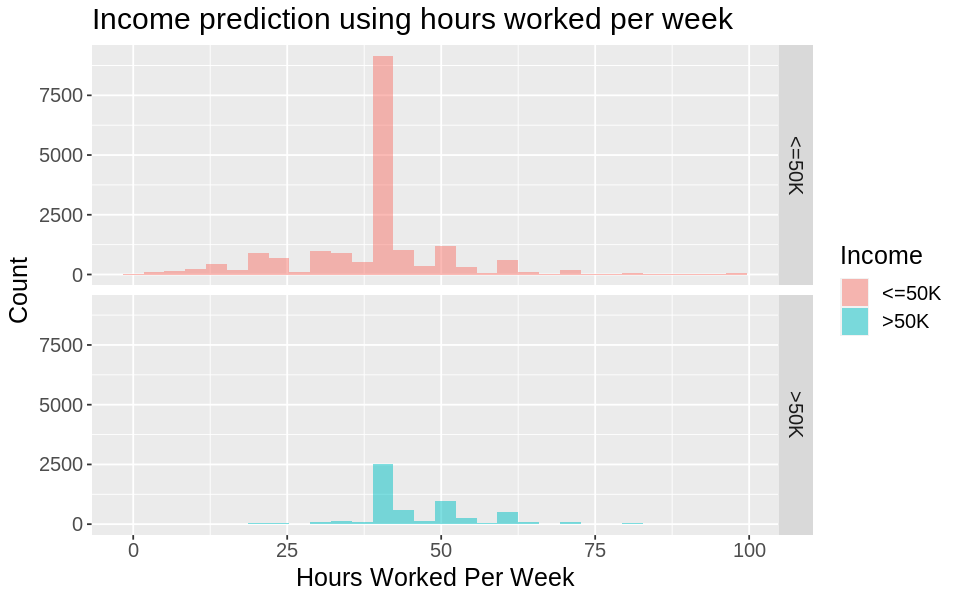

In [20]:
options(repr.plot.width = 8, repr.plot.height = 5)
hours_hist <- census_train %>%
    ggplot(aes(x = hours_per_week, fill = income)) +
    geom_histogram(alpha = 0.5, position = "identity") +
    facet_grid(rows = vars(income)) +
    labs(x = "Hours Worked Per Week", y = "Count", fill = "Income") + 
    ggtitle("Income prediction using hours worked per week") + 
    theme(text = element_text(size = 15)) 
hours_hist

##### Figure 2. Income prediction using hours worked per week.

This shows that most people work 40 hours a week, pretty much regardless of the income they make. This makes sense bc 40 hours is a standard work week in the US.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



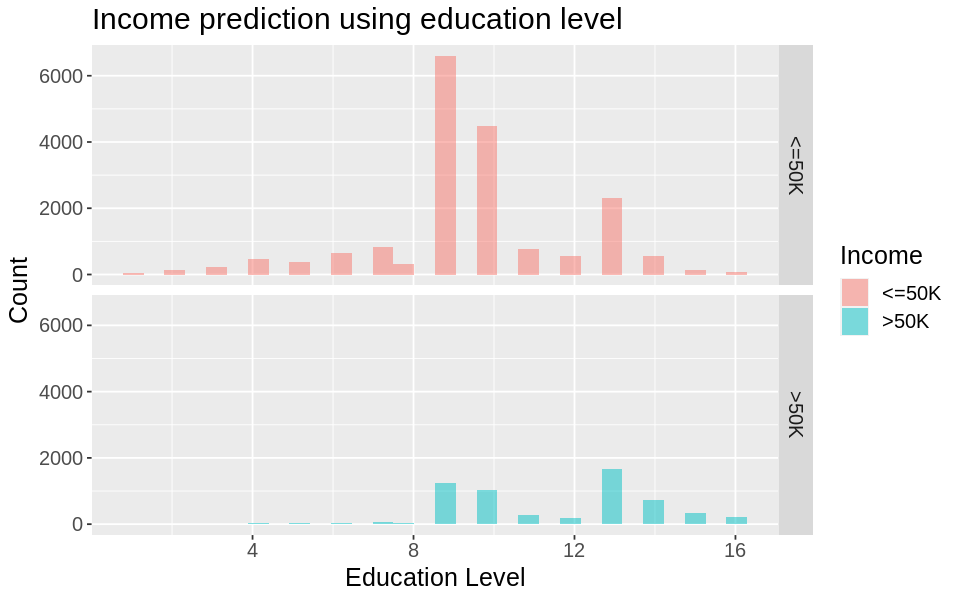

In [21]:
options(repr.plot.width = 8, repr.plot.height = 5)
education_hist <- census_train %>%
    ggplot(aes(x = education_num, fill = income)) +
    geom_histogram(alpha = 0.5, position = "identity") +
    facet_grid(rows = vars(income)) +
    labs(x = "Education Level", y = "Count", fill = "Income") + 
    ggtitle("Income prediction using education level") + 
    theme(text = element_text(size = 15)) 
education_hist

##### Figure 3. Income prediction using education level.

It looks like most people who make less than 50k a year have an education level of 9 or 10, but there is a wide variety of levels. On the other hand, people who make more than 50k almost exclusively have an education level of higher than 9. This is pretty interesting!

### Data Analysis

Since our target variable is a category with two different classes (less than or equal to 50k and greater than 50k), we know this is a classification problem. To model our data, we will be using K-nearest neighbors (K-NN). In brief, this algorithm uses Euclidian distance to determine labels for new data points based on similarity.

Now, we will be analyzing our data with K-NN classification. 

We are using census_train and census_test from above.

First, we want to create the recipe and K-NN model for our workflow. We will be using the recipe to scale and center our data. 
We do not know what the optimal K for our model is yet, so we need to use cross-validation to tune our model. We will be using 5 fold cross-validation and testing values of K from 1 to 100 in intervals of 5. 

In [22]:
recipe <- recipe(income ~ ., data = census_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

vfold <- vfold_cv(census_train, v = 5, strata = income)

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

knn_results <- workflow() %>%
  add_recipe(recipe) %>%
  add_model(knn_spec) %>%
  tune_grid(resamples = vfold, grid = k_vals) %>%
  collect_metrics()

Currently, our results are in knn_results, so we need to extract only the information we are interested in. For this project, we will be using accuracy as the metric to evaluate our model. 

In [23]:
accuracies <- knn_results %>%
  filter(.metric == "accuracy")                    

Now, we will plot the accuracies to determine the best K for our model.

In [25]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Number of Neighbors", y = "Accuracy Estimate") +
  ggtitle("Accuracy vs K Neighbors") +
  theme(text = element_text(size = 15)) 

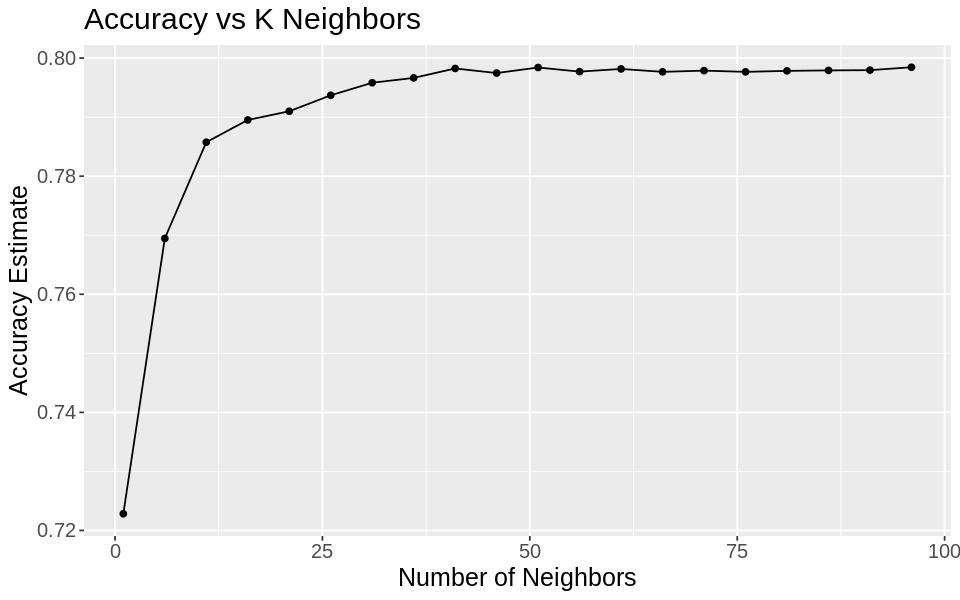

In [26]:
accuracy_vs_k

##### Figure 4. Accuracy vs K.

It looks like accuracy is pretty high when K is greater than 40. We want to pick a K that has a high accuracy and a similar accuracy to nearby values, while keeping the cost of training low. We have selected K = 45 for our model. Using this K value, we retrain our model and add it into the workflow.

In [38]:
new_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 45) %>%
  set_engine("kknn") %>%
  set_mode("classification")

knn_fit <- workflow() %>%
  add_recipe(recipe) %>%
  add_model(new_knn_spec) %>%
  fit(data = census_train)

Now that we have our model, we can test it on our test set to evaluate how well it is doing.

In [ ]:
predictions <- predict(knn_fit, census_test) %>%
  bind_cols(census_test)      

##### Table 4. Evaluate the estimated accuracy of the classifier.

In [39]:
metrics(predictions, truth = income, estimate = .pred_class) %>%
    filter(.metric == "accuracy")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7938575


It looks like our model has an accuracy of 0.79, which is not bad! Below we use a confusion matrix as another visualization of the performance of our model.

In [40]:
conf_mat(predictions, truth = income, estimate = .pred_class)

          Truth
Prediction <=50K >50K
     <=50K  5710 1208
     >50K    470  752

##### Figure 5. Confusion matrix for the classifier.

## Discussion

#### Summary of Results

We used K-NN classification as our model. Our tuned classifier uses 45 neighbors and has an accuracy of 0.79. This means that out of 8140 observations, our model predicted 6462 correctly. We can use the confusion matrix above to analyze other metrics as well, but we will not discuss those as they were not taught in this class (Figure 5).

#### Is this what we expected to find?

From the results of our exploratory data analysis graphs, we expected individuals in their 30s with higher education, to have a higher income (Figure 1, 2). Hours worked per week did not seem like it would have a significant impact since most people work 40 hours a week (Figure 3). These predictions support the external information we found. On average, individuals who have higher education also have a higher income.[4] These people will take longer to complete education, which may explain why most people don't earn more than 50k until their late twenties (Figure 1).

Our model performed relatively well, and we would trust it as a classifier to analyze additional real world data. Although the slight class imbalance did not affect our results a lot, we think that if the classes were balanced our model would probably perform even better.

#### What impact could such findings have?

With this model, we could predict an individual's income level based on various factors. This dataset also gave us visual insight on the variables that affect a person’s income. 

The results from this project could inform people of the qualities they should improve upon to increase their income. For example, since it looked like higher education levels increased income level, individuals could strive to continue education. Governments could also assist by subsidizing tuition or offering free education. Overall, these findings could provide information on how income gaps could be minimized in the future. 

#### What future questions could this lead to?

Since this dataset is from 1994, how will outcomes differ compared to current data (2021)? In other words, if we have a new observation from 2021, how accurate would the prediction be if we used the model we built from a 1994 data?

Since we were not able to analyze categorical variables, how would these affect our predictions? Our data had quite a few categorical variables, such as occupation, work class, and native country, that would probably generate some interesting results.

It is important to keep in mind that this data is based in the US, where education is relatively accessible to most people. This makes us wonder whether there are specific areas in the US where education is lower and why? Standard of living is also different in various parts of the US - how important is making greater than 50k? 50k may be more than enough money to live comfortably in some parts of the US, while in others it may be difficult to even pay rent.


## References

1. Amadeo, K. (n.d.). The true cause of income inequality in America. The Balance. Retrieved December 7, 2021, from https://www.thebalance.com/income-inequality-in-america-3306190. 
2. Becker, B. and Kohavi, R. (1996). UCI Machine Learning Repository: Adult Data Set. Retrieved December 7, 2021, from https://archive.ics.uci.edu/ml/datasets/Adult. 
3. Horowitz, J. M., Igielnik, R., & Kochhar, R. (2020, August 17). Trends in U.S. income and wealth inequality. Pew Research Center's Social & Demographic Trends Project. Retrieved December 6, 2021, from https://www.pewresearch.org/social-trends/2020/01/09/trends-in-income-and-wealth-inequality/. 
4. The college payoff: Education, occupations, Lifetime earnings. CEW Georgetown. (2021, August 13). Retrieved December 7, 2021, from https://cew.georgetown.edu/cew-reports/the-college-payoff/. 